# Executive Hour & Energy price forecasting

This notebook contains a selection of the models that were generated during the course of our work on energy price forecasting. The notebook will initialize each model, train it and then score it according to the validation and test data sets. Finally, all models are compared againts the chosen baseline model.  

The target of our project is to predict the day-ahead price (`DA_price`) of electricty in New York city area. The DA price is the price of electricty that is charged at time `t` for delivery of electricty at time `t+24` hours. In contrast to the real-time (`RT`) price, which is for buying and selling electricty on the spot for immediate consumption and is therefore quite volatile, the `DA` price mechanism allows for an element of predictability and stability. 

In our case, we choose a reasonable baseline model: `DA_price` at time `t` is the same as the `DA_price` at time `t-24h`. 

**This notebook is for our multi-step models. That is, the next 24 hours is predicted all at once, with the exception of the ARIMA model.**

### Group Members:
Irem Altiner, Souparna Purohit, Nicolas Fortier, Rouzbeh Yazdi  
Mentor: Julian Rosen

In [1]:
## imports:
## our own models
import rouz_helpers as rhelp
import rouz_model as rmodel ## Rouz's model(s) --> Linear, Deep and CNN models
import LSTM_multistep as nmodel ## Nic's model(s) --> multi-layered LSTM
import ARIMA_forecast_method as imodel ## Irem's model --> ARIMA
import XGB as smodel ## Souparna's model --> XGBoost regressor model

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter, NullLocator
from datetime import datetime

from tensorflow import keras
import tensorflow as tf

In [3]:
## I am running on an M1 Mac machine and for some reason
## running tensorflow with GPU is a __pain__
tf.config.set_visible_devices([], "GPU")

In [4]:
val_performance, performance = {}, {}

## Baseline, linear, dense and convolutional

Presented here are 4 models. In the figures below, the presented examples are chosen from the _test_ set.

In [5]:
## Read in the data, remove the first few days
data_frames = rhelp.read_data(loc='../../data_processing/final_data/')
train_df, val_df, test_df, price_mean, price_std, col_indices = rhelp.process_data(*data_frames)

In [6]:
"""
    Only one windowing option here:
        Given 24 hours of inputs (input_width) predict 24 hours into the future
"""
PATIENCE   = 10
MAX_EPOCHS = 200

NFEATURES      = train_df.shape[1]
OUT_STEPS      = 24
CONVWIDTH      = 5
BATCH_SIZE     = 1024
LEARNING_RATE = 0.0001
multi_window   = rhelp.WindowGenerator(input_width=24,
                                   label_width=OUT_STEPS,
                                   shift=OUT_STEPS,
                                   batch_size=BATCH_SIZE,
                                   train_df=train_df,
                                   val_df=val_df,
                                   test_df=test_df)

In [7]:
## Models:
baseline_model = rmodel.Baseline("Baseline")
linear_model   = rmodel.LinearMultiStep("Linear", OUT_STEPS, NFEATURES)
dense_model    = rmodel.DenseMultistep("Dense", OUT_STEPS, NFEATURES)
cnn_model      = rmodel.ConvolutionalMultiStep("CNN", CONVWIDTH, OUT_STEPS, NFEATURES)

### Baseline
The first is the baseline where take the next 24 values of day-ahead price to be the previous 24 hours of this observable.

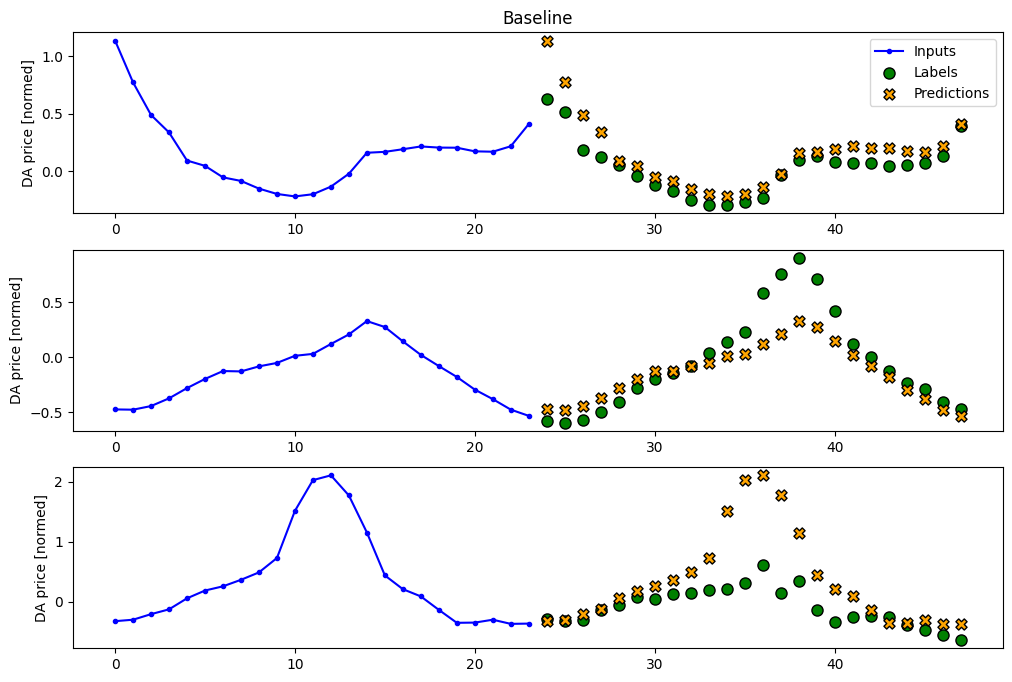

In [8]:
## Now train and test the models
baseline_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.RootMeanSquaredError()])
fig1 = multi_window.plot(baseline_model, colors=['blue','green','orange'], title='Baseline')

### Linear Model:
The model takes in a 24 hour window of data but only considers the last hour. Based on that, a dense layer with linear activation is trained and attempts at a single-shot prediction of the next 24 hours.

In [9]:
history_linear = rmodel.compile_and_fit(linear_model, multi_window, 
                                        patience=PATIENCE, max_epochs=MAX_EPOCHS, 
                                        learning_rate=LEARNING_RATE)

Epoch 1/200
18/18 [==============================] - 1s 16ms/step - loss: 0.9715 - root_mean_squared_error: 0.9857 - val_loss: 0.9001 - val_root_mean_squared_error: 0.9487
Epoch 2/200
18/18 [==============================] - 0s 15ms/step - loss: 0.9219 - root_mean_squared_error: 0.9602 - val_loss: 0.8726 - val_root_mean_squared_error: 0.9341
Epoch 3/200
18/18 [==============================] - 0s 13ms/step - loss: 0.8774 - root_mean_squared_error: 0.9367 - val_loss: 0.8473 - val_root_mean_squared_error: 0.9205
Epoch 4/200
18/18 [==============================] - 0s 12ms/step - loss: 0.8381 - root_mean_squared_error: 0.9155 - val_loss: 0.8239 - val_root_mean_squared_error: 0.9077
Epoch 5/200
18/18 [==============================] - 0s 14ms/step - loss: 0.8032 - root_mean_squared_error: 0.8962 - val_loss: 0.8022 - val_root_mean_squared_error: 0.8957
Epoch 6/200
18/18 [==============================] - 0s 11ms/step - loss: 0.7724 - root_mean_squared_error: 0.8789 - val_loss: 0.7822 - val_

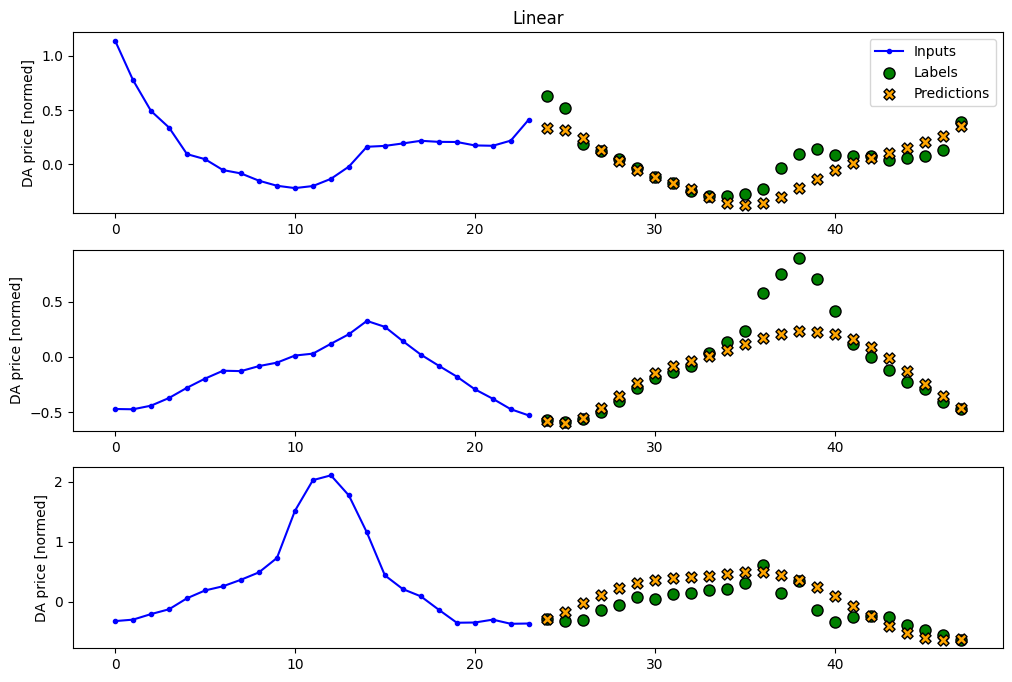

In [10]:
fig2 = multi_window.plot(linear_model, colors=['blue','green','orange'], title='Linear')

### Dense Model:
Similar to the linear model with the exception that before the linear layer, we introduce a dense and fully connected layer with ReLU activation. It will be able to capture more of the complexity of the data.

In [11]:
history_dense = rmodel.compile_and_fit(dense_model, multi_window, 
                                       patience=PATIENCE, 
                                       max_epochs=MAX_EPOCHS,
                                    learning_rate=LEARNING_RATE)

Epoch 1/200
18/18 [==============================] - 1s 21ms/step - loss: 0.9590 - root_mean_squared_error: 0.9793 - val_loss: 0.8744 - val_root_mean_squared_error: 0.9351
Epoch 2/200
18/18 [==============================] - 0s 18ms/step - loss: 0.8725 - root_mean_squared_error: 0.9341 - val_loss: 0.8140 - val_root_mean_squared_error: 0.9022
Epoch 3/200
18/18 [==============================] - 0s 18ms/step - loss: 0.7797 - root_mean_squared_error: 0.8830 - val_loss: 0.7525 - val_root_mean_squared_error: 0.8675
Epoch 4/200
18/18 [==============================] - 0s 17ms/step - loss: 0.6918 - root_mean_squared_error: 0.8317 - val_loss: 0.6959 - val_root_mean_squared_error: 0.8342
Epoch 5/200
18/18 [==============================] - 0s 16ms/step - loss: 0.6213 - root_mean_squared_error: 0.7882 - val_loss: 0.6475 - val_root_mean_squared_error: 0.8047
Epoch 6/200
18/18 [==============================] - 0s 18ms/step - loss: 0.5702 - root_mean_squared_error: 0.7551 - val_loss: 0.6053 - val_

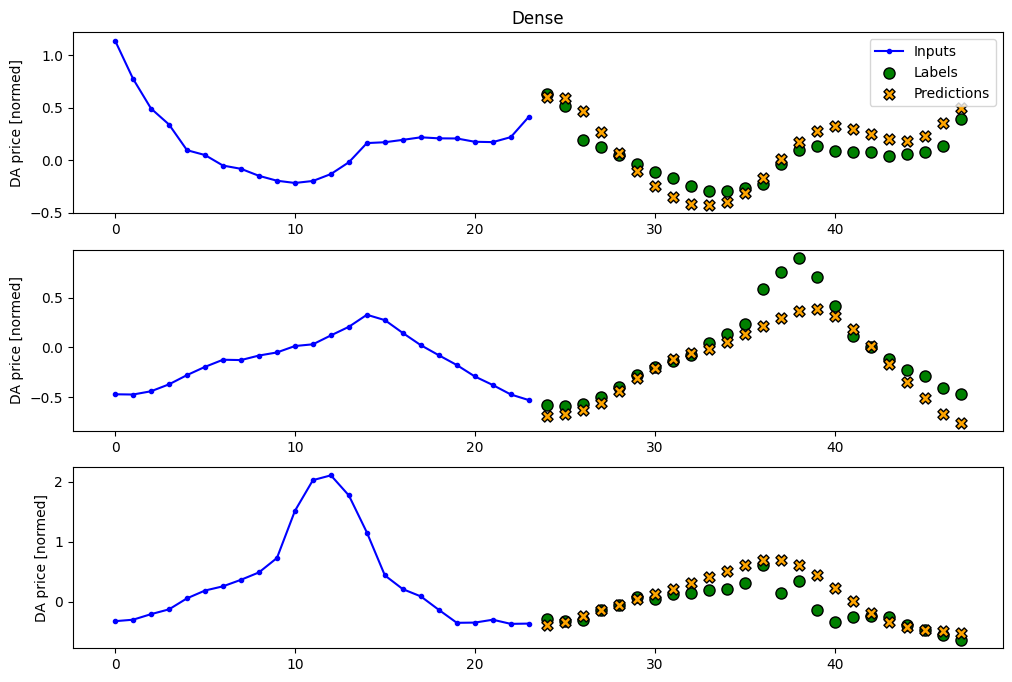

In [12]:
fig3 = multi_window.plot(dense_model, colors=['blue','green','orange'], title='Dense')

### CNN Model
Similar to the previous two but instead of a dense, fully connected layer seeing only the last time step, the model applies a convolutional layer and see as much of the previous time steps as the convolutional width (defined a few cells back) allows. 

In [13]:
history_cnn = rmodel.compile_and_fit(cnn_model, multi_window, 
                                     patience=PATIENCE, 
                                     max_epochs=MAX_EPOCHS,
                                     learning_rate=LEARNING_RATE)

Epoch 1/200
18/18 [==============================] - 1s 22ms/step - loss: 0.9496 - root_mean_squared_error: 0.9745 - val_loss: 0.8590 - val_root_mean_squared_error: 0.9268
Epoch 2/200
18/18 [==============================] - 0s 21ms/step - loss: 0.8012 - root_mean_squared_error: 0.8951 - val_loss: 0.7619 - val_root_mean_squared_error: 0.8729
Epoch 3/200
18/18 [==============================] - 0s 20ms/step - loss: 0.6563 - root_mean_squared_error: 0.8101 - val_loss: 0.6925 - val_root_mean_squared_error: 0.8322
Epoch 4/200
18/18 [==============================] - 1s 19ms/step - loss: 0.5900 - root_mean_squared_error: 0.7681 - val_loss: 0.6322 - val_root_mean_squared_error: 0.7951
Epoch 5/200
18/18 [==============================] - 1s 28ms/step - loss: 0.5384 - root_mean_squared_error: 0.7337 - val_loss: 0.5724 - val_root_mean_squared_error: 0.7565
Epoch 6/200
18/18 [==============================] - 0s 18ms/step - loss: 0.4863 - root_mean_squared_error: 0.6974 - val_loss: 0.5181 - val_

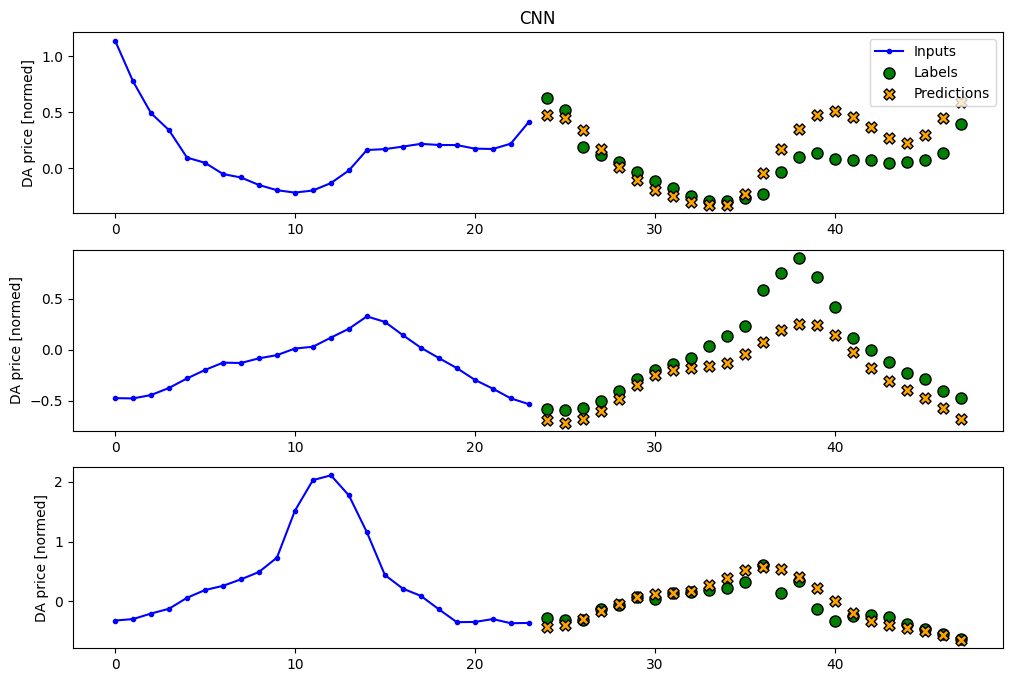

In [14]:
fig4 = multi_window.plot(cnn_model, colors=['blue','green','orange'], title='CNN')

In [15]:
## Compute RMSE for the above 4 models:
for model in [baseline_model, linear_model, dense_model, cnn_model]:
    name = model.name_
    print(f"Dealing with model: {name}")
    rms_err_val = rmodel.get_rmse(model, multi_window.val, 
                           price_std,  
                           index=col_indices['DA_price'])
    rms_err_test = rmodel.get_rmse(model, multi_window.test, 
                           price_std, 
                           index=col_indices['DA_price'])
    val_performance[name] = rms_err_val
    performance[name]     = rms_err_test

Dealing with model: Baseline
Dealing with model: Linear
Dealing with model: Dense
Dealing with model: CNN


I can also show histories of the fitting process:

Text(0.02, 0.5, 'Validation Loss (MSE) on normed data')

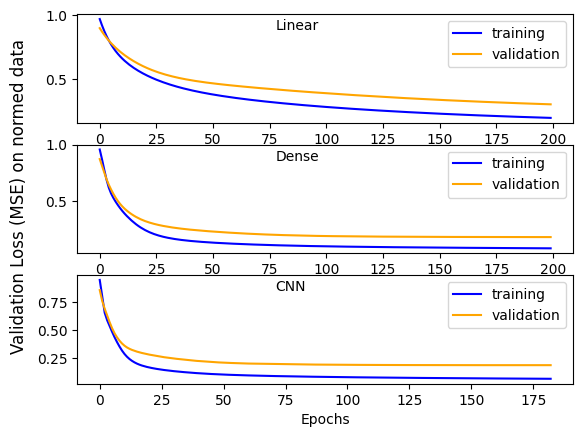

In [16]:
histories = {'Linear':history_linear,
                 'Dense':history_dense, 
                 'CNN': history_cnn}
fig5, axes = plt.subplots(len(histories), 1)
for hist, ax in zip(histories, axes):
    history = histories[hist]
    ax.plot(history.history['loss'], label='training', color='blue')
    ax.plot(history.history['val_loss'], label='validation', color='orange')
    ax.legend(loc='best')
    ax.text(0.4, 0.85, hist,transform=ax.transAxes)
    ax.xaxis.set_minor_locator(NullLocator())
    ax.xaxis.set_minor_formatter(NullFormatter())
axes[-1].set_xlabel('Epochs')
fig5.supylabel('Validation Loss (MSE) on normed data')

## LSTM Neural Network

In [17]:
model, [val_yhat, val_y], [test_yhat, test_y] = nmodel.main()

STARTING TRAINING MODEL
Epoch 1/200
250/250 - 14s - loss: 0.0050 - 14s/epoch - 55ms/step
Epoch 2/200
250/250 - 14s - loss: 0.0035 - 14s/epoch - 55ms/step
Epoch 3/200
250/250 - 14s - loss: 0.0030 - 14s/epoch - 58ms/step
Epoch 4/200
250/250 - 14s - loss: 0.0028 - 14s/epoch - 56ms/step
Epoch 5/200
250/250 - 14s - loss: 0.0025 - 14s/epoch - 56ms/step
Epoch 6/200
250/250 - 14s - loss: 0.0024 - 14s/epoch - 57ms/step
Epoch 7/200
250/250 - 15s - loss: 0.0022 - 15s/epoch - 59ms/step
Epoch 8/200
250/250 - 15s - loss: 0.0021 - 15s/epoch - 60ms/step
Epoch 9/200
250/250 - 15s - loss: 0.0020 - 15s/epoch - 60ms/step
Epoch 10/200
250/250 - 14s - loss: 0.0018 - 14s/epoch - 58ms/step
Epoch 11/200
250/250 - 14s - loss: 0.0017 - 14s/epoch - 55ms/step
Epoch 12/200
250/250 - 14s - loss: 0.0016 - 14s/epoch - 55ms/step
Epoch 13/200
250/250 - 13s - loss: 0.0015 - 13s/epoch - 52ms/step
Epoch 14/200
250/250 - 15s - loss: 0.0014 - 15s/epoch - 59ms/step
Epoch 15/200
250/250 - 14s - loss: 0.0013 - 14s/epoch - 58ms/

In [18]:
val_performance["LSTM"] = 25
performance["LSTM"] = 28

## XGBoost Regressor
This model was originally developed for single time step predictions. However it was found that modification for multi-step predictions did not materially modify the performance of the model. Thus we present the single step results here (in the interest of time).

In [19]:
loc='../../data_processing/final_data/'
val_df   = pd.read_csv(loc+"ordered_seasonal_validation_set.csv")
test_df  = pd.read_csv(loc+"ordered_test_set.csv")
train_df = pd.read_csv(loc+"ordered_train_set.csv")

In [20]:
xgb = smodel.XGBModel(train_df, val_df, test_df)
xgb.train()

[0]	validation_0-rmse:56.97922	validation_1-rmse:46.27609
[100]	validation_0-rmse:26.46222	validation_1-rmse:27.95871


/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/erdos/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [16:35:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:17.23641	validation_1-rmse:23.80671
[300]	validation_0-rmse:14.68612	validation_1-rmse:22.21214
[400]	validation_0-rmse:13.78530	validation_1-rmse:21.60153
[500]	validation_0-rmse:13.26881	validation_1-rmse:21.23711
[600]	validation_0-rmse:12.87255	validation_1-rmse:21.00576
[700]	validation_0-rmse:12.55255	validation_1-rmse:20.83193
[800]	validation_0-rmse:12.27867	validation_1-rmse:20.74457
[900]	validation_0-rmse:12.04143	validation_1-rmse:20.72414
[935]	validation_0-rmse:11.96864	validation_1-rmse:20.72277


In [21]:
_, xgb_rmse, _ = xgb.predict(pred_on='validation')
val_performance["XGB Regressor"] = xgb_rmse
_, xgb_rmse, _ = xgb.predict(pred_on='test')
performance["XGB Regressor"] = xgb_rmse

Overriding pred_df with df_validation!
Overriding pred_df with df_test!


## ARIMA Model

In [22]:
loc='../../data_processing/final_data/'
train_df= pd.read_csv(loc+"ordered_train_set.csv",parse_dates=['time'])
test_df = pd.read_csv(loc+"full_ordered_test_set.csv",parse_dates=['time'])

In [23]:
arima = imodel.ArimaModel(train_df, test_df)
arima.train(maxiter=50)

/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/erdos/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/erdos/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           38     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.35125D+00    |proj g|=  1.01650D-01

At iterate    5    f=  3.32869D+00    |proj g|=  3.89532D-03

At iterate   10    f=  3.32757D+00    |proj g|=  1.17679D-02

At iterate   15    f=  3.32494D+00    |proj g|=  1.58928D-02

At iterate   20    f=  3.32300D+00    |proj g|=  1.73418D-02

At iterate   25    f=  3.32166D+00    |proj g|=  7.64381D-03

At iterate   30    f=  3.31925D+00    |proj g|=  1.19057D-02

At iterate   35    f=  3.31766D+00    |proj g|=  5.08405D-03

At iterate   40    f=  3.31711D+00    |proj g|=  5.69089D-03

At iterate   45    f=  3.31685D+00    |proj g|=  4.01041D-03

At iterate   50    f=  3.31673D+00    |proj g|=  1.26798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/erdos/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
arima.get_preds()

/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/ExecutiveHour/final/multi_step_models/ARIMA_forecast_method.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.predictions[f'Day {i+1} fcast'] = pd.concat([forecasts, ser])
/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/ExecutiveHour/final/multi_step_models/ARIMA_forecast_method.py:75: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.predictions[f'Day {i+1} fcast'] = pd.concat([forecasts, ser])
/Users/rmyazdi/Documents/Dat_Sci_Learning/ERDOS-Fall-2023/

,Day 1 fcast,Day 2 fcast,Day 3 fcast,Day 4 fcast,Day 5 fcast,Day 6 fcast,Day 7 fcast,Day 8 fcast,Day 9 fcast,Day 10 fcast,...,Day 265 fcast,Day 266 fcast,Day 267 fcast,Day 268 fcast,Day 269 fcast,Day 270 fcast,Day 271 fcast,Day 272 fcast,Day 273 fcast,Day 274 fcast
0,10.158178,3.562154,29.764743,5.790477,37.961618,26.993531,43.889166,42.947938,41.615063,41.246613,...,22.580431,22.247352,22.455064,21.977015,23.147333,27.017893,24.907178,24.594020,25.911726,25.457142
1,10.282294,3.242197,27.960800,5.393533,37.443233,27.108434,44.488576,41.226795,40.793103,38.927261,...,19.933304,20.158182,20.832838,20.403489,21.718184,24.868606,22.820917,21.994357,23.566817,23.398818
2,9.545382,2.717657,26.959365,3.309746,35.137512,25.631391,42.765662,39.810262,39.181295,37.668689,...,19.355880,18.673642,20.059754,19.572944,20.303999,23.327565,21.001495,20.595505,22.132420,22.072520
3,11.098123,2.861464,26.338771,2.719962,34.065564,24.788324,42.377846,39.790109,38.905795,38.063125,...,19.025910,19.001734,19.438496,19.256283,19.760802,22.411467,19.393668,19.340160,21.098119,21.564265
4,12.745854,3.402362,26.738839,2.995078,32.027942,25.809310,42.120262,41.009815,39.649629,38.502284,...,18.470085,18.929958,19.533454,19.401914,19.965869,23.092927,19.514879,19.909530,21.327101,21.861438
5,17.346617,4.254685,27.282752,5.591104,31.896963,27.831739,42.599213,43.510932,40.375324,40.550630,...,18.245465,21.102286,20.368013,20.407705,21.231688,24.869888,20.939624,20.923056,22.339864,22.888343
6,24.162205,7.396002,31.220616,10.597138,33.047936,31.440809,44.548975,46.758914,42.981535,44.202795,...,19.191901,21.816482,21.772098,21.710104,22.260121,26.101993,21.817661,21.932753,23.722328,24.369784
7,35.326706,17.702332,42.094918,18.106841,36.869930,34.743887,47.846108,55.363492,49.995728,51.331161,...,20.193110,23.544873,22.570700,23.204602,23.974254,27.497085,23.066117,22.640647,24.655291,25.696423
8,36.912358,22.999017,43.865397,20.200604,39.993982,36.198053,50.009848,56.889018,52.023766,52.014669,...,21.533972,24.153723,23.498840,24.502336,25.250325,28.417436,24.138465,23.966225,25.500333,26.528295
9,32.404792,24.108119,40.141871,21.652573,41.278407,38.239534,51.107306,55.875531,52.477172,50.781145,...,23.198033,26.300378,25.136571,25.628482,25.949422,29.037274,24.891411,24.905395,26.076021,27.207928


In [25]:
performance['ARIMA']       = arima.RMSE
val_performance['ARIMA']   = 0.0

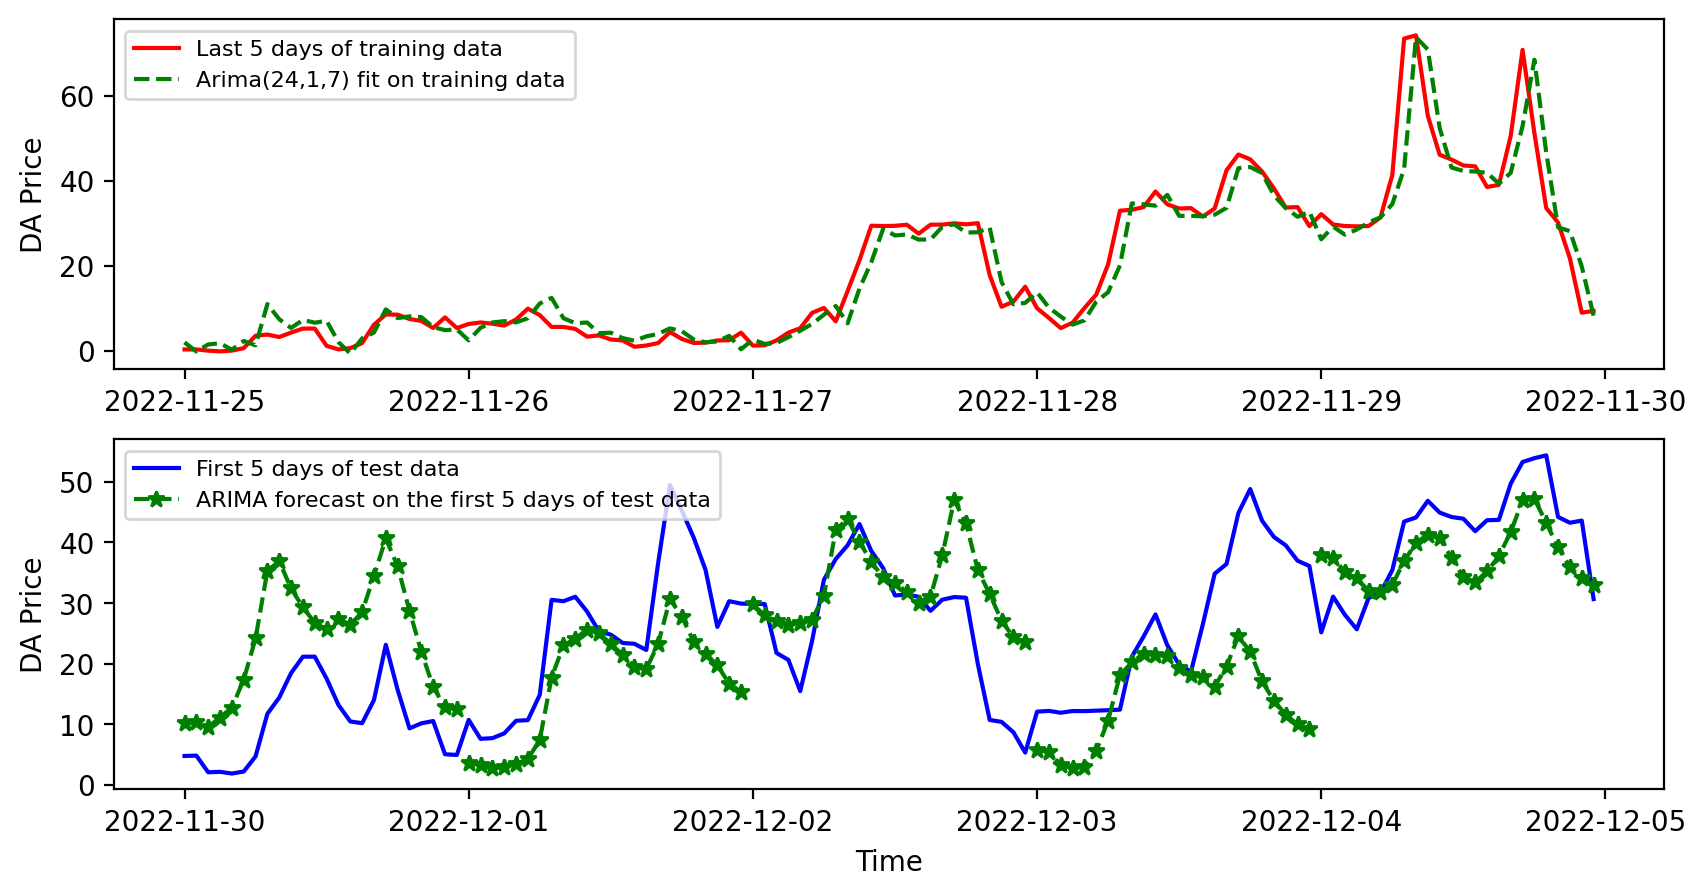

In [26]:
fig, axes = arima.sample_plot()

## Clean up for a table

In [30]:

results = pd.DataFrame({'models':val_performance.keys(),
                        'Validation':val_performance.values(),
                        'Test':performance.values()})
results
# results = pd.DataFrame({'models':['Baseline', 'Linear', 'Dense', 'CNN', 'LSTM','XGB Regressor', 'ARIMA'],
#                         'Validation':[21.22,20.19,19.64,19.98,25,20.71,0],
#                         'Test':[20.42, 20.13, 19.34, 19.65, 28,22,20.64]})
# results

,models,Validation,Test
0,Baseline,21.224231,20.421635
1,Linear,20.198366,20.140126
2,Dense,19.388108,19.318118
3,CNN,20.130734,19.921863
4,LSTM,25.000000,28.000000
5,XGB Regressor,20.718347,22.009341
6,ARIMA,0.000000,20.646964


# Scores

Now let's see the scores:

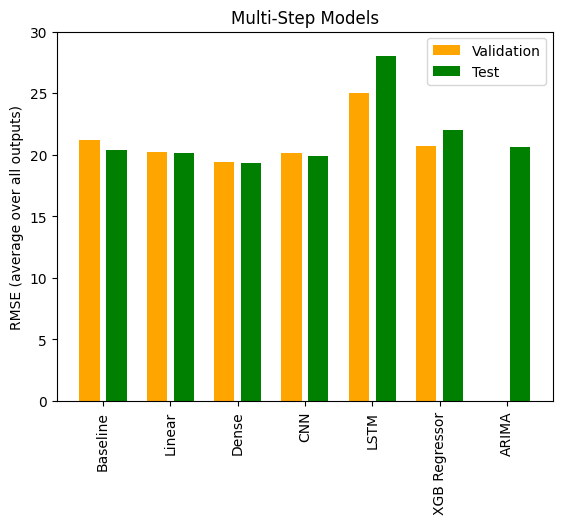

In [31]:
width=0.3
x = np.arange(len(results))
fig6, ax = plt.subplots(1, 1)
ax.set_title(f"Multi-Step Models")
ax.bar(x - 0.2, results['Validation'].values, width, label="Validation", color='orange')
ax.bar(x + 0.2, results['Test'].values, width, label="Test", color='green')
ax.set_xticks(ticks=x, labels=results['models'], rotation=90)
ax.set_ylabel("RMSE (average over all outputs)")
ax.xaxis.set_minor_locator(NullLocator())
ax.xaxis.set_minor_formatter(NullFormatter())
ax.set_ylim(bottom=-.01, top=30)
_ = ax.legend()